In [ ]:
!pip install pennylane --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 957 kB 4.4 MB/s 
     |████████████████████████████████| 9.3 MB 38.8 MB/s 
     |████████████████████████████████| 1.6 MB 38.7 MB/s 
     |████████████████████████████████| 108 kB 71.0 MB/s 


In [ ]:
import pennylane as qml
import pennylane.numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import torchvision.transforms as transforms
from torchvision.datasets import MNIST

from sklearn.decomposition import PCA

from google.colab import drive
drive.mount('/content/drive')

import time
import datetime


Mounted at /content/drive


In [ ]:
class DataframeDataset(Dataset):
  def __init__(self, data):
    if isinstance(data, pd.DataFrame):
      self.data = data
    else:
      self.data = data
          
  def __getitem__(self, index):
    label = self.data.iloc[index]['label']
    image = self.data.iloc[index][1:]
    return torch.tensor(image), torch.tensor(label)

  def __len__(self):
      return len(self.data)


class TrainTestLoader(object):
  def __init__(self, data_type="MNIST"):
    self.data = data_type

    self.training_data=None
    self.test_data=None

    self.train_X = None
    self.train_y = None
    self.test_X = None
    self.test_y = None

    if self.data == "MNIST":
      download_root = "./MNIST_DATASET"
      mnist_transform = transforms.Compose([
                          transforms.ToTensor()
                        ])

      self.training_data = MNIST(download_root,
                        train=True,
                        download=True,
                        transform=mnist_transform)

      self.test_data = MNIST(download_root,
                        train=False,
                        download=True,
                        transform=mnist_transform)
    
      train_shape = self.training_data.data.shape
      test_shape = self.test_data.data.shape

      train_X = self.training_data.data.reshape((train_shape[0],
                                train_shape[1]*train_shape[2])) / 255.0
      train_y = self.training_data.targets

      test_X = self.test_data.data.reshape((test_shape[0],
                                test_shape[1]*test_shape[2])) / 255.0
      test_y = self.test_data.targets

      #0과 1에 해당하는 data만 추출
      self.train_X = train_X[(train_y==0) | (train_y==1)]
      self.train_y = train_y[(train_y==0) | (train_y==1)]
      self.test_X = test_X[(test_y==0) | (test_y==1)][:1000]
      self.test_y = test_y[(test_y==0) | (test_y==1)][:1000]

  def scale_pca(self, n_dim):
    
    ###여기에 standardscaler 있었는데 그냥 안 함

    pca = PCA(n_components=n_dim)
    
    self.train_X = pca.fit_transform(self.train_X)
    self.test_X = pca.transform(self.test_X)

    self.train_X = pd.DataFrame(self.train_X)
    self.train_X.insert(0, 'label', self.train_y)
    self.test_X = pd.DataFrame(self.test_X)
    self.test_X.insert(0, 'label', self.test_y)

    self.training_data = self.train_X
    self.test_data = self.test_X
  
  def scale_resize(self, size):
    train_X = self.train_X
    test_X = self.test_X

    t = transforms.Resize(size=(size, 1))
    train_X = train_X.reshape(train_X.shape[0],train_X.shape[1],1)
    train_X = torch.squeeze(t(train_X))
    self.train_X = pd.DataFrame(train_X)
    self.train_X.insert(0, 'label', self.train_y)

    test_X = test_X.reshape(test_X.shape[0],test_X.shape[1],1)
    test_X = torch.squeeze(t(test_X))
    self.test_X = pd.DataFrame(test_X)
    self.test_X.insert(0, 'label', self.test_y)
    
    self.training_data = self.train_X
    self.test_data = self.test_X

  def return_dataset(self):
      return DataframeDataset(self.training_data), DataframeDataset(self.test_data)

  # def save(self):
  #     self.training_data.to_csv("./training_data.csv", index = False)
  #     self.test_data.to_csv("./test_data.csv", index = False)

  # def load(self):
  #     self.training_data = read_csv("./training_data.csv")
  #     self.test_data = read_csv("./test_data.csv")



In [ ]:
#QCNN_circuit

class QCNN():
  def __init__(self, n_qubits, conv_ansatz, pooling_ansatz):
    if conv_ansatz == "ConvCirc1":
      self.conv_ansatz = ConvCirc1()
    elif conv_ansatz == "ConvCircSU4":
      self.conv_ansatz = ConvCircSU4()

    self.pooling_ansatz = pooling_ansatz
    self.n_qubits = n_qubits

  def construct_circuit(self, params, data):
    # insert initial state as data in n_qubits, not total_qubits
    qml.AmplitudeEmbedding(data, wires=range(self.n_qubits),
                           pad_with=0, normalize=True)
    ansatz_param_num = self.conv_ansatz.num_params
    param1 = params[0:ansatz_param_num]
    param2 = params[ansatz_param_num: 2 * ansatz_param_num]
    param3 = params[2 * ansatz_param_num: 3 * ansatz_param_num]

    param4 = params[3 * ansatz_param_num: 3 * ansatz_param_num + 2]
    param5 = params[3 * ansatz_param_num + 2: 3 * ansatz_param_num + 4]
    param6 = params[3 * ansatz_param_num + 4: 3 * ansatz_param_num + 6]

    self.conv_layer1(param1)
    self.pooling_layer1(param4)

    self.conv_layer2(param2)
    self.pooling_layer2(param5)

    self.conv_layer3(param3)
    self.pooling_layer3(param6)


  # Convolutional layers
  def conv_layer1(self, params):
    for i in range(0, 8, 2):
        self.conv_ansatz.apply(params, wires=[i, i + 1])
    self.conv_ansatz.apply(params, wires=[0, 7])
    for i in range(1, 7, 2):
        self.conv_ansatz.apply(params, wires=[i, i + 1])

  def conv_layer2(self, params):
    self.conv_ansatz.apply(params, wires=[1, 3])
    self.conv_ansatz.apply(params, wires=[5, 7])
    self.conv_ansatz.apply(params, wires=[1, 7])
    self.conv_ansatz.apply(params, wires=[3, 5])

  def conv_layer3(self, params):
    self.conv_ansatz.apply(params, wires=[3,7])


  # Pooling layers
  def pooling_layer1(self, params):
      for i in range(0, 8, 2):
          self.pooling_ansatz.apply(params, wires=[i, i+1])

  def pooling_layer2(self, params):
      self.pooling_ansatz.apply(params, wires=[1,3])
      self.pooling_ansatz.apply(params, wires=[5,7])

  def pooling_layer3(self, params):
      self.pooling_ansatz.apply(params, wires=[7,3])


  def Calculate_Param_Num(self):
    ansatz_param = self.conv_ansatz.num_params
    pooling_param = self.pooling_ansatz.num_params
    total_param_num = ansatz_param*3 + pooling_param*3
    return total_param_num


# def estimated_label(params, data):
#     return circuit(params, data) 


In [ ]:
## ansatz 여기에서 추가 가능

# Convolutional Layer Ansatz
class ConvCirc1():
  def __init__(self) -> None:
    self.num_params = 2

  def apply(self, weights, wires):
    qml.RY(weights[0], wires = wires[0])
    qml.RY(weights[1], wires = wires[1])
    qml.CNOT(wires = wires)

# Convolutional Layer Ansatz SU(4)
class ConvCircSU4():

  def __init__(self) -> None:
      self.num_params = 15

  def apply(self, weights, wires):
      qml.U3(weights[0], weights[1], weights[2], wires = wires[0])
      qml.U3(weights[3], weights[4], weights[5], wires = wires[1])
      qml.CNOT(wires = [wires[0], wires[1]])
      qml.RY(weights[6], wires = wires[0])
      qml.RZ(weights[7], wires = wires[1])
      qml.CNOT(wires = [wires[1], wires[0]])
      qml.RY(weights[8], wires=wires[0])
      qml.CNOT(wires = [wires[0], wires[1]])
      qml.U3(weights[9], weights[10], weights[11], wires = wires[0])
      qml.U3(weights[12], weights[13], weights[14], wires = wires[1])

# Pooling Layer Ansatz
class PoolingCirc():
    def __init__(self) -> None:
        self.num_params = 2
    
    def apply(self, weights, wires):
        qml.CRY(weights[0], wires = wires)
        qml.PauliX(wires[0])
        qml.CRY(weights[1], wires = wires)
        qml.PauliX(wires[0])



In [ ]:
## train 준비
from torch.nn import MSELoss, CrossEntropyLoss
from torch.optim import Adam, Adagrad
from torch.utils.data import random_split

import os
import torchvision
import torchvision.transforms as transforms

from torch.utils.tensorboard import SummaryWriter
import datetime

##################  hyperparam  ##################
EPOCHS = 3
BATCH_SIZE = 25
SEED = 42
LEARNING_RATE = 0.01

VAL_SIZE = 1000

conv_ansatz = "ConvCirc1"
##################  hyperparam  ##################
###########hyperparam 몇개 생략함######


qcnn = QCNN(n_qubits=8, conv_ansatz= conv_ansatz,
            pooling_ansatz = PoolingCirc())

dev = qml.device("default.qubit", wires=qcnn.n_qubits)
@qml.qnode(dev, interface="torch")
def circuit(params, data):
  qcnn.construct_circuit(params, data)
  return qml.expval(qml.PauliZ(3))


###내 방식대로 수정함
loader = TrainTestLoader("MNIST")
#### loader.scale_pca(n_dim=) or loader.scale_resize(size=) 중에서 선택 #######
loader.scale_pca(n_dim=256)
training_set, test_set = loader.return_dataset()

validation_set = DataframeDataset(training_set.data[:VAL_SIZE])
training_set = DataframeDataset(training_set.data[VAL_SIZE:])

training_loader = \
        DataLoader(training_set, batch_size=BATCH_SIZE,
        shuffle=True, generator=torch.Generator().manual_seed(SEED))
validation_loader = \
        DataLoader(validation_set, batch_size=len(validation_set),
        shuffle=False, generator=torch.Generator().manual_seed(SEED))
test_loader = \
        DataLoader(test_set, batch_size=len(test_set),
        shuffle=False, generator=torch.Generator().manual_seed(SEED))

# Report data sizes
print(f"Train set #:      {len(training_set)}")
print(f"Validation set #: {len(validation_set)}")
print(f"Test set #:       {len(test_set)}")

loss_fn = MSELoss()

params = torch.rand(qcnn.Calculate_Param_Num(),
                    requires_grad=True,
                    generator=torch.Generator().manual_seed(SEED))

optimizer = Adam([params], lr =LEARNING_RATE)


Train set #:      11665
Validation set #: 1000
Test set #:       1000


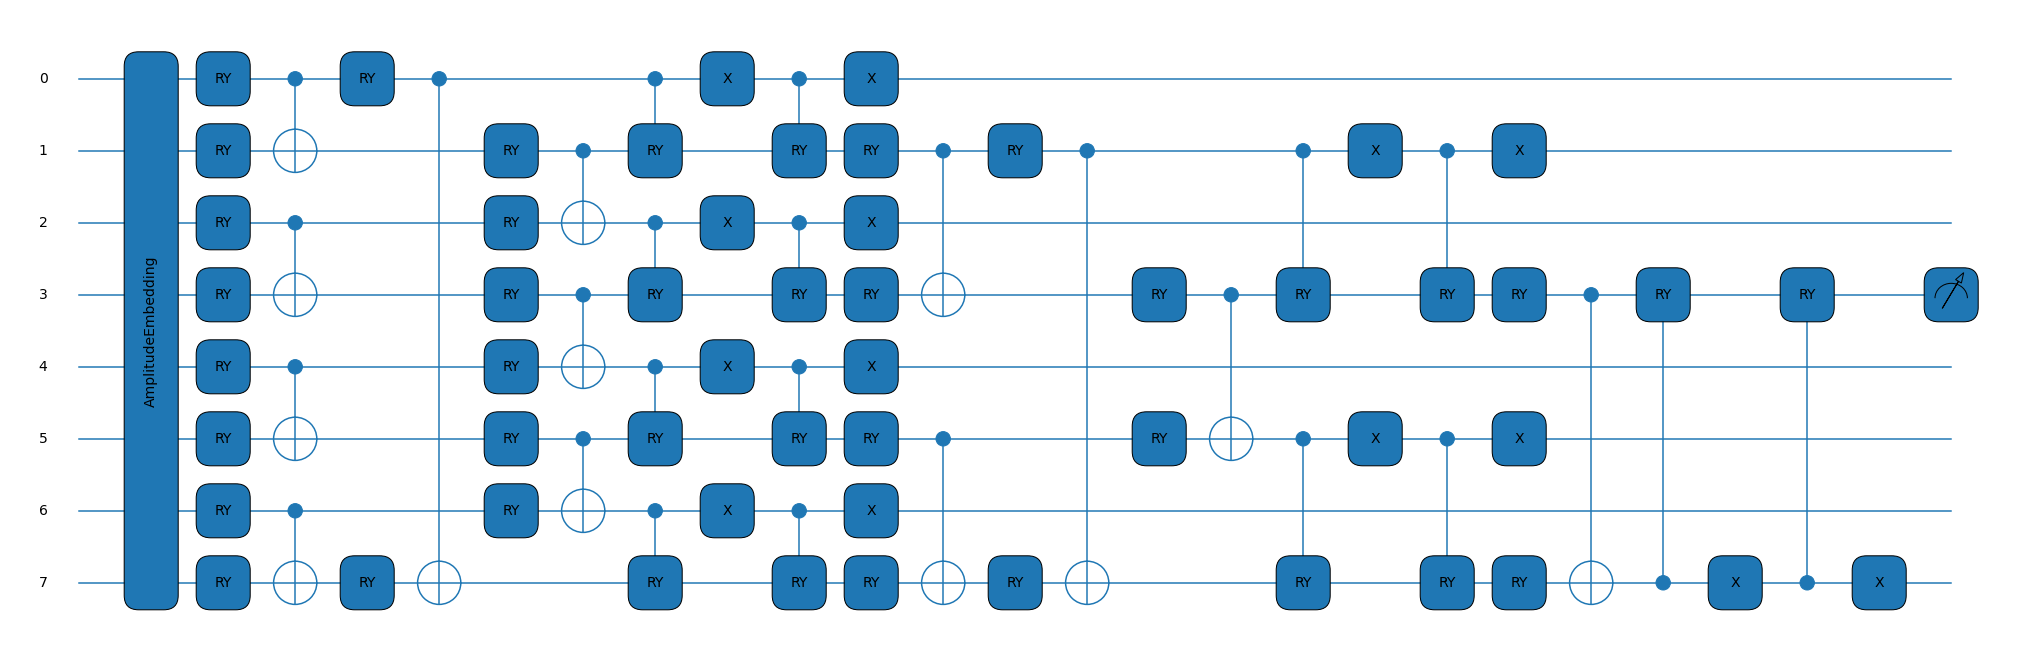

In [ ]:
import matplotlib.pyplot as plt
data = torch.rand(256)
fig, ax = qml.draw_mpl(circuit)(params,data)
plt.show()

In [ ]:
## train
from tqdm.notebook import tqdm
import logging
from pathlib import Path

##################### 할 때마다 file path 고치기 #####################
filepath = "/content/drive/MyDrive/박경덕교수님연구실/MY_QCNN/" +\
            conv_ansatz+"_result"
if os.path.exists(filepath) == False:
    os.makedirs(filepath)
def estimated_label(params, data):
    return circuit(params, data) # TODO: customize your extimated label

writer = SummaryWriter(log_dir=filepath)




# loss_list = []
# avg_loss_list = []
# avg_vloss_list = []
# history_of_parameters = []


##############epoch만큼 trianing#######################

# for epoch in range(EPOCHS):
#   avg_loss = 0.0
#   for i, data in tqdm(enumerate(training_loader),
#                       total=len(training_loader), desc=f"{epoch+1}"):
#     inputs, labels = data
#     optimizer.zero_grad()
#     loss = torch.tensor(0, dtype=torch.float64)
#     for input, label in zip(inputs, labels):
#         output = estimated_label(params, input.to(torch.float64))
#         loss+=loss_fn(output, 2*label.to(torch.float64)-1)/len(labels)
#     loss.backward()
#     optimizer.step()
#     avg_loss += loss.item()
#     loss_list.append(loss.item())
#     writer.add_scalar('local training loss',
#                       loss.item(), epoch*len(training_loader)+i)
#     np.save(filepath+'/'+f'epoch{epoch}_iter{epoch*len(training_loader)+i}',
#             params.detach().numpy())
#     # logger.debug("epoch: {} batch_index: {} --- loss: {} \t params: {}".format(epoch+1, i+1, loss.item(), params.detach().numpy()))

#   avg_loss = avg_loss/len(training_loader)
#   avg_loss_list.append(avg_loss)
  
  
#   with torch.no_grad():
#     avg_vloss = 0.0
#     #val_score는 내가 추가
#     val_score = 0
#     for i, vdata in enumerate(validation_loader):
#       vloss = torch.tensor(0, dtype=torch.float64)
#       vinputs, vlabels = vdata
#       for vinput, vlabel in zip(vinputs, vlabels):
#         voutput = estimated_label(params, vinput.to(torch.float64))
#         val_label = 2*vlabel.to(torch.float64)-1
#         vloss += loss_fn(voutput, val_label)/len(vlabels)
#         if np.abs(voutput - val_label) < 1:
#           val_score += 1
#       avg_vloss += vloss.item()
#     avg_vloss = avg_vloss / len(validation_set)
#     avg_vloss_list.append(avg_vloss)
#     history_of_parameters.append(params.numpy())
#     np.save(filepath+'/'+f'vaidataion_epoch{epoch}', params.numpy())
#   # print('LOSS train {} valid {}'.format(avg_loss, avg_vloss))
  
#     val_score = val_score / len(validation_set)
#     print(f"Epoch {epoch} val score = {val_score}")

#   # Log the running loss averaged per batch
#   # for both training and test
#   writer.add_scalar('validation Loss', avg_vloss, epoch)
#   writer.flush()
#       # print('{}: {}'.format(i, loss.item()))




In [ ]:
#200 iter만 training

def training_during_num_iter(iter_num):
  start_t = time.time()
  loss_list = []
  avg_vloss_list = []
  history_of_parameters = []
  for i, data in enumerate(training_loader):
    if i == iter_num:
      break
      
    inputs, labels = data
    optimizer.zero_grad()
    loss = torch.tensor(0, dtype=torch.float64)
    for input, label in zip(inputs, labels):
        output = estimated_label(params, input.to(torch.float64))
        loss+=loss_fn(output, 2*label.to(torch.float64)-1)/len(labels)
    loss.backward()
    optimizer.step()
    loss_list.append(loss.item())
    writer.add_scalar('training loss', loss.item(), i)
    np.save(filepath+'/'+f'iter{i}', params.detach().numpy())
    # logger.debug("epoch: {} batch_index: {} --- loss: {} \t params: {}".format(epoch+1, i+1, loss.item(), params.detach().numpy()))
    if (i+1)%10 == 0:
      print(f"Iteration {i+1:>3} loss: {loss.item()}")

  end_t = time.time()
  sec = end_t - start_t
  str(datetime.timedelta(seconds = sec)).split(".")[0]
  total_time = str(datetime.timedelta(seconds = sec)).split(".")[0]
  print(f"Training during {iter_num} iterations finishes (taken time: {total_time}) ")
  return loss_list, total_time


In [ ]:
######################## training start #########################
## iteration 몇번 할지 지정
iter_num=200

loss_list, total_time = training_during_num_iter(iter_num=iter_num)



Iteration  10 loss: 1.0199173842979672
Iteration  20 loss: 1.0104143806785892
Iteration  30 loss: 0.9084095047670147
Iteration  40 loss: 0.9287901314697324
Iteration  50 loss: 0.8806536622270983
Iteration  60 loss: 0.8691624823674027
Iteration  70 loss: 0.86501294737495
Iteration  80 loss: 1.033326398249955
Iteration  90 loss: 0.827362765750375
Iteration 100 loss: 0.8569290093781745
Iteration 110 loss: 0.9251963706937077
Iteration 120 loss: 0.8389682447536982
Iteration 130 loss: 0.6648420967697258
Iteration 140 loss: 1.085886114268135
Iteration 150 loss: 0.8083538360892285
Iteration 160 loss: 0.8093862618226404
Iteration 170 loss: 0.7585721529610552
Iteration 180 loss: 0.7564049111135637
Iteration 190 loss: 0.7632382842006
Iteration 200 loss: 0.6926470843104581
Training during 200 iterations finishes (taken time: 0:06:40) 


In [ ]:
print(params)
params.shape

tensor([ 0.9556,  1.3286,  0.1690,  0.8651,  0.2160,  0.2406, -0.2921,  1.1678,
         0.4242,  0.3056,  1.9817,  1.6137], requires_grad=True)


torch.Size([12])

In [ ]:
# test_set 정확도
with torch.no_grad():
  pred_label_arr = []
  true_label_arr = []
  for t_datas, test_labels in test_loader:
    for t_data, label in zip(t_datas, test_labels):
      pred_label_arr.append(\
          estimated_label(params, t_data.to(torch.float64)).numpy() > 0)
      true_label_arr.append(label.numpy())
  accuracy = sum(np.array(pred_label_arr)==\
                 np.array(true_label_arr))   /   len(true_label_arr)
  accuracy = accuracy.item()
  print("Test score:", accuracy)

import json
with open(filepath+"/"+"summary.json","w") as fp:
  json.dump(dict(
      accuracy = accuracy,
      loss = loss_list,
      total_time = total_time
  ), fp = fp)


Test score: 0.823


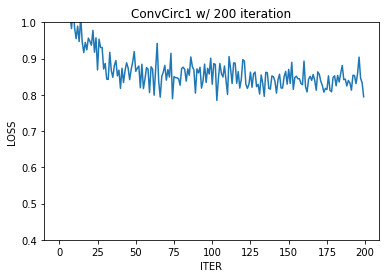

In [ ]:
# loss plot

# loss_list
# avg_loss_list
import matplotlib.pyplot as plt
plt.plot(loss_list)
plt.title(f"{conv_ansatz} w/ {str(iter_num)} iteration")
plt.xlabel("ITER")
plt.ylabel("LOSS")
plt.ylim((0.4, 1.0))

plt.show()


In [ ]:
###### tensorboard 실행 #######
!tensorboard --logdir=filepath+"/"

2022-08-13 14:45:23.961030: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected

NOTE: Using experimental fast data loading logic. To disable, pass
    "--load_fast=false" and report issues on GitHub. More details:
    https://github.com/tensorflow/tensorboard/issues/4784

Serving TensorBoard on localhost; to expose to the network, use a proxy or pass --bind_all
TensorBoard 2.8.0 at http://localhost:6006/ (Press CTRL+C to quit)
